In [2]:
import os

clean_dir = 'dataset/train/clean_trainset_28spk_wav'
noisy_dir = 'dataset/train/noisy_trainset_28spk_wav'


clean_wavs_path = [os.path.join(clean_dir, file) for file in os.listdir(clean_dir) if file.endswith('.wav')]


noisy_wavs_path = [os.path.join(noisy_dir, file) for file in os.listdir(noisy_dir) if file.endswith('.wav')]

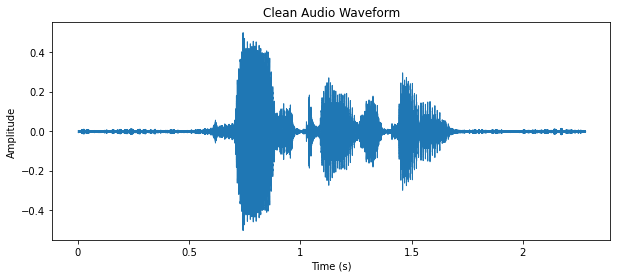

In [3]:
import librosa
import librosa.display
import matplotlib.pyplot as plt


audio_file_path = clean_wavs_path[0]
y, sr = librosa.load(audio_file_path)


plt.figure(figsize=(10, 4))
librosa.display.waveshow(y, sr=sr)
plt.title('Clean Audio Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

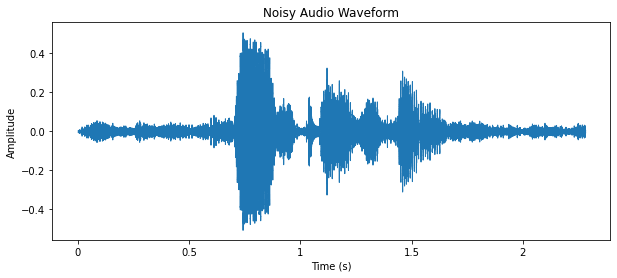

In [4]:
audio_file_path = noisy_wavs_path[0]
y, sr = librosa.load(audio_file_path)


plt.figure(figsize=(10, 4))
librosa.display.waveshow(y, sr=sr)
plt.title('Noisy Audio Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

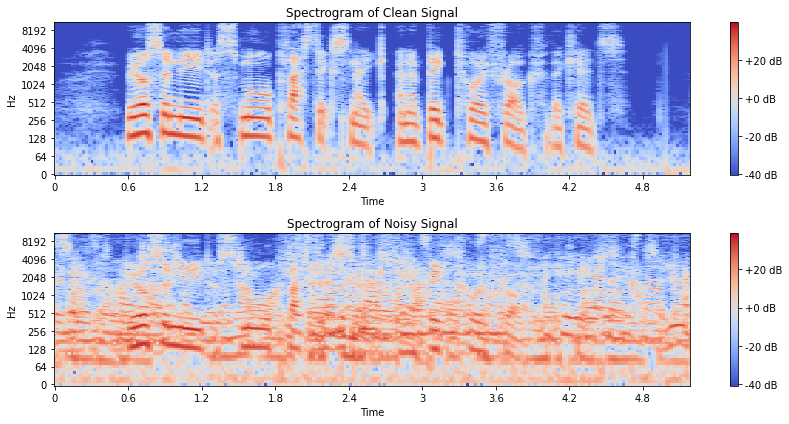

In [5]:
import numpy as np

audio_file1 = clean_wavs_path[3]
audio_file2 = noisy_wavs_path[3]

signal1, sr1 = librosa.load(audio_file1)

signal2, sr2 = librosa.load(audio_file2)

stft1 = librosa.stft(signal1)

stft2 = librosa.stft(signal2)

stft1_db = librosa.amplitude_to_db(np.abs(stft1))
stft2_db = librosa.amplitude_to_db(np.abs(stft2))

plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
librosa.display.specshow(stft1_db, sr=sr1, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram of Clean Signal')

plt.subplot(2, 1, 2)
librosa.display.specshow(stft2_db, sr=sr2, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram of Noisy Signal')

plt.tight_layout()
plt.show()




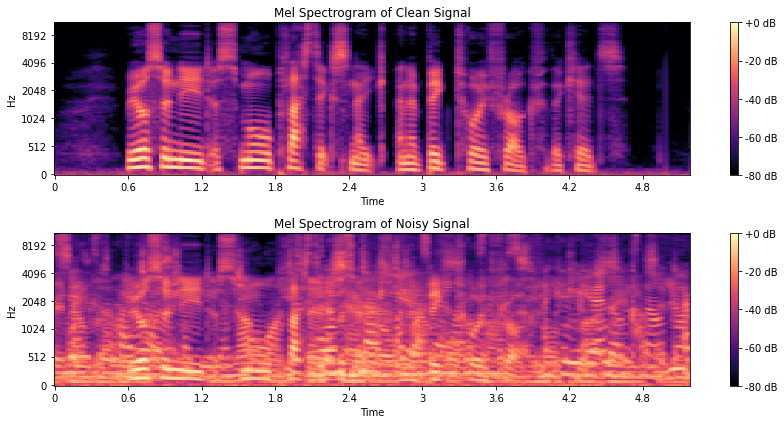

In [6]:
audio_file1 = clean_wavs_path[3]
audio_file2 = noisy_wavs_path[3]

signal1, sr1 = librosa.load(audio_file1)

signal2, sr2 = librosa.load(audio_file2)

mel_spec1 = librosa.feature.melspectrogram(y=signal1, sr=sr1)

mel_spec1_db = librosa.power_to_db(mel_spec1, ref=np.max)

mel_spec2 = librosa.feature.melspectrogram(y=signal2, sr=sr2)

mel_spec2_db = librosa.power_to_db(mel_spec2, ref=np.max)

plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
librosa.display.specshow(mel_spec1_db, sr=sr1, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram of Clean Signal')

plt.subplot(2, 1, 2)
librosa.display.specshow(mel_spec2_db, sr=sr2, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram of Noisy Signal')

plt.tight_layout()
plt.show()


In [47]:
class config:
    target_sample_rate=48000
    duration=4
    n_fft=1024
    hop_length=512
    n_mels=64
    batch_size=128
    learning_rate=1e-6
    epochs=6

In [48]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchaudio
import torch.nn.functional as F

target_sample_rate = config.target_sample_rate
duration = config.duration

def load_and_preprocess_audio(audio_paths, target_sample_rate, duration):
    mel_specs = []
    for audio_path in audio_paths:
        signal, sr = torchaudio.load(audio_path)

        if sr != target_sample_rate:
            signal = torchaudio.transforms.Resample(sr, target_sample_rate)(signal)

        if signal.shape[0] > 1:
            signal = torch.mean(signal, dim=0, keepdim=True)

        num_samples = target_sample_rate * duration
        if signal.shape[1] > num_samples:
            signal = signal[:, :num_samples]
        elif signal.shape[1] < num_samples:
            num_missing_samples = num_samples - signal.shape[1]
            signal = F.pad(signal, (0, num_missing_samples))

        mel_spec = torchaudio.transforms.MelSpectrogram(
            sample_rate=target_sample_rate, n_mels=config.n_mels)(signal)
        mel_spec = mel_spec / torch.abs(mel_spec).max()  

        mel_specs.append(mel_spec)

    return torch.stack(mel_specs)

class CustomDataset(Dataset):
    def __init__(self, clean_data_path, noisy_data_path, target_sample_rate, duration):
        self.clean_paths = clean_data_path
        self.noisy_paths = noisy_data_path
        self.target_sample_rate = target_sample_rate
        self.duration = duration

    def __len__(self):
        return len(self.clean_paths)

    def __getitem__(self, index):
        clean_mel = load_and_preprocess_audio([self.clean_paths[index]], self.target_sample_rate, self.duration)
        noisy_mel = load_and_preprocess_audio([self.noisy_paths[index]], self.target_sample_rate, self.duration)
        return clean_mel, noisy_mel


In [49]:
mel_spectrogram = torchaudio.transforms.MelSpectrogram(sample_rate=config.target_sample_rate,
                                                      n_fft=config.n_fft, 
                                                      hop_length=config.hop_length, 
                                                      n_mels=config.n_mels)


test_clean = clean_wavs_path[:10]
test_noisy = noisy_wavs_path[:10]

training_dataset = CustomDataset(clean_wavs_path[10:11000], noisy_wavs_path[10:11000], mel_spectrogram)
validation_dataset = CustomDataset(clean_wavs_path[11000:], noisy_wavs_path[11000:], mel_spectrogram)

In [50]:
trainloader = DataLoader(training_dataset, batch_size=config.batch_size)
validloader = DataLoader(validation_dataset, batch_size=config.batch_size)

In [61]:
trainloader_shape = trainloader.dataset
print("Training Data Loader Shape:", trainloader_shape)

validloader_shape = validloader.dataset
print("Validation Data Loader Shape:", validloader_shape)


Training Data Loader Shape: <__main__.CustomDataset object at 0x00000206C49890C0>
Validation Data Loader Shape: <__main__.CustomDataset object at 0x00000206C4989E10>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

<Figure size 1080x648 with 0 Axes>

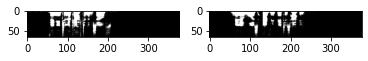

In [51]:
import matplotlib.pyplot as plt
import torchvision
import numpy as np

# Assuming you have a trainloader set up previously

def imageshow_ax(image, ax):
    npimage = image.numpy()
    ax.imshow(np.transpose(npimage, (1, 2, 0)))

plt.figure(figsize=(15, 9))
fig, axs = plt.subplots(1, 2)

for batch in trainloader:
    # 'batch' now contains a batch of data, including images and labels
    for image_number, ax in enumerate(axs.ravel()):
        imageshow_ax(torchvision.utils.make_grid(batch[0][image_number][:4]), ax)


In [52]:
import torch
import torch.nn as nn

class UNetGenerator(nn.Module):
    def __init__(self, chnls_in=1, chnls_out=1):
        super(UNetGenerator, self).__init__()
        self.down_conv_layer_1 = DownConvBlock(chnls_in, 64, norm=False)
        self.down_conv_layer_2 = DownConvBlock(64, 128)
        self.down_conv_layer_3 = DownConvBlock(128, 256)
        self.down_conv_layer_4 = DownConvBlock(256, 256, dropout=0.5)
        self.down_conv_layer_5 = DownConvBlock(256, 256, dropout=0.5)
        self.down_conv_layer_6 = DownConvBlock(256, 256, dropout=0.5)

        self.up_conv_layer_1 = UpConvBlock(256, 256, kernel_size=(2,3), stride=2, padding=0, dropout=0.5)# 256+256 6 5 kernel_size=(2, 3), stride=2, padding=0
        self.up_conv_layer_2 = UpConvBlock(512, 256, kernel_size=(2,3), stride=2, padding=0, dropout=0.5) # 256+256 1 4
        self.up_conv_layer_3 = UpConvBlock(512, 256, kernel_size=(2,3), stride=2, padding=0, dropout=0.5) # 2 3
        self.up_conv_layer_4 = UpConvBlock(512, 128, dropout=0.5) # 3 2
        self.up_conv_layer_5 = UpConvBlock(256, 64) # 4 1
        self.up_conv_layer_6 = UpConvBlock(512, 128)
        self.up_conv_layer_7 = UpConvBlock(256, 64)
        self.upsample_layer = nn.Upsample(scale_factor=2)
        self.zero_pad = nn.ZeroPad2d((1, 0, 1, 0))
        self.conv_layer_1 = nn.Conv2d(128, chnls_out, 4, padding=1)
        self.activation = nn.Tanh()
    
    def forward(self, x):
        #print('x', x.shape)
        enc1 = self.down_conv_layer_1(x) # [4, 64, 32, 188]
        print('1', enc1.shape)
        enc2 = self.down_conv_layer_2(enc1) # [4, 128, 16, 94]
        print('2', enc2.shape)
        enc3 = self.down_conv_layer_3(enc2) # [4, 256, 8, 47]
        print('3', enc3.shape)
        enc4 = self.down_conv_layer_4(enc3) # [4, 256, 4, 23]
        print('4', enc4.shape)
        enc5 = self.down_conv_layer_5(enc4) # [4, 256, 2, 11]
        print('5', enc5.shape)
        enc6 = self.down_conv_layer_6(enc5) # [4, 256, 1, 5]
        #print('6', enc6.shape)
 
        dec1 = self.up_conv_layer_1(enc6, enc5)# enc6: 256 + enc5: 256 [4, 512, 2, 11]
        #print('d1', dec1.shape)
        dec2 = self.up_conv_layer_2(dec1, enc4)# enc4: 256 + dec1=enc5*2: [4, 512, 4, 23]
        #print('d2', dec2.shape)
        dec3 = self.up_conv_layer_3(dec2, enc3)# enc3: 256 + dec2=enc4*2: [4, 512, 8, 47]
        #print('d3', dec3.shape)
        dec4 = self.up_conv_layer_4(dec3, enc2)# enc2: 128 + dec3=enc3*2: [4, 256, 16, 94]
        #print('d4', dec4.shape)
        dec5 = self.up_conv_layer_5(dec4, enc1)# enc1: 64 + dec4=enc1*2: [4, 128, 32, 188]
        #print('d5', dec5.shape)
      
        final = self.upsample_layer(dec5)
        final = self.zero_pad(final)
        final = self.conv_layer_1(final)
        #print(final.shape)
        return final

class UpConvBlock(nn.Module):
    def __init__(self, ip_sz, op_sz, kernel_size=4, stride= 2, padding=1 ,dropout=0.0):
        super(UpConvBlock, self).__init__()
        self.layers = [
            nn.ConvTranspose2d(ip_sz, op_sz, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.InstanceNorm2d(op_sz),
            nn.ReLU(),
        ]
        if dropout:
            self.layers += [nn.Dropout(dropout)]
    def forward(self, x, enc_ip):
        x = nn.Sequential(*(self.layers))(x)
        op = torch.cat((x, enc_ip), 1)
        return op


class DownConvBlock(nn.Module):
    def __init__(self, ip_sz, op_sz, kernel_size=4, norm=True, dropout=0.0):
        super(DownConvBlock, self).__init__()
        self.layers = [nn.Conv2d(ip_sz, op_sz, kernel_size, 2, 1)]
        if norm:
            self.layers.append(nn.InstanceNorm2d(op_sz))
        self.layers += [nn.LeakyReLU(0.2)]
        if dropout:
            self.layers += [nn.Dropout(dropout)]
    def forward(self, x):
        op = nn.Sequential(*(self.layers))(x)
        return op
    
model = UNetGenerator()

In [53]:
from tqdm import tqdm

train_losses = []


def train(dataloader, model, epoch, loss_fn, optimizer, device):
    model.train()
    total_loss = 0.0
    for i, (clean, noisy) in enumerate(tqdm(dataloader)):
        clean = clean.to(device)
        noisy = noisy.to(device)
        
        optimizer.zero_grad()
        pred = model(noisy)
        curr_loss = loss_fn(pred, clean)
        curr_loss.backward()
        optimizer.step()

        total_loss += curr_loss
        
        if i % 1000 == 0:
            print('[Epoch number : %d, Mini-batches: %5d] loss: %.3f' %
                  (epoch + 1, i + 1, total_loss / 200))
            total_loss = 0.0
            
        train_losses.append(curr_loss)

def val(dataloader, model, epoch, loss_fn, device):
    model.eval()
    total_loss = 0.0
    print('-------------------------')
    with torch.no_grad():
        for i, (clean, noisy) in enumerate(tqdm(dataloader)):
            clean = clean.to(device)
            noisy = noisy.to(device)
        
            output = model(noisy)
            loss = loss_fn(output, clean)
            total_loss += loss
            if i % 100 == 0:
                print('[Valid Epoch number : %d, Mini-batches: %5d] loss: %.3f' %
                      (epoch + 1, i + 1, total_loss / 200))
                total_loss = 0.0


In [ ]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
loss_fn = torch.nn.functional.mse_loss
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model = UNetGenerator().to(device)

for epoch in range(config.epochs):
    train(trainloader, model, epoch, loss_fn, optimizer, device)
    val(validloader, model, epoch, loss_fn, device)

In [58]:
model_path = 'unet_model.h5'
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

Model saved to unet_model.h5
